In [1]:
%reload_ext autoreload
%autoreload 2

from astroquery.gaia import Gaia
import astropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import utils as ut
import plot_utils as pu
import os

In [4]:
dist_pc = 100

adql_query = ut.distance_query_(dist_pc)

job = Gaia.launch_job_async(adql_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
data = job.get_results()
data = ut.preprocess_data(data)
data_f1 = data[data['parallax_over_error'] > 10]
data_f1 = data_f1[data_f1['astrometric_excess_noise'] < 1]
data_f2 = data_f1[data_f1['phot_bp_mean_flux_over_error'] > 10]
data_f2 = data_f2[data_f2['phot_rp_mean_flux_over_error'] > 10]


0.15488601077034136 0.8818788505447561


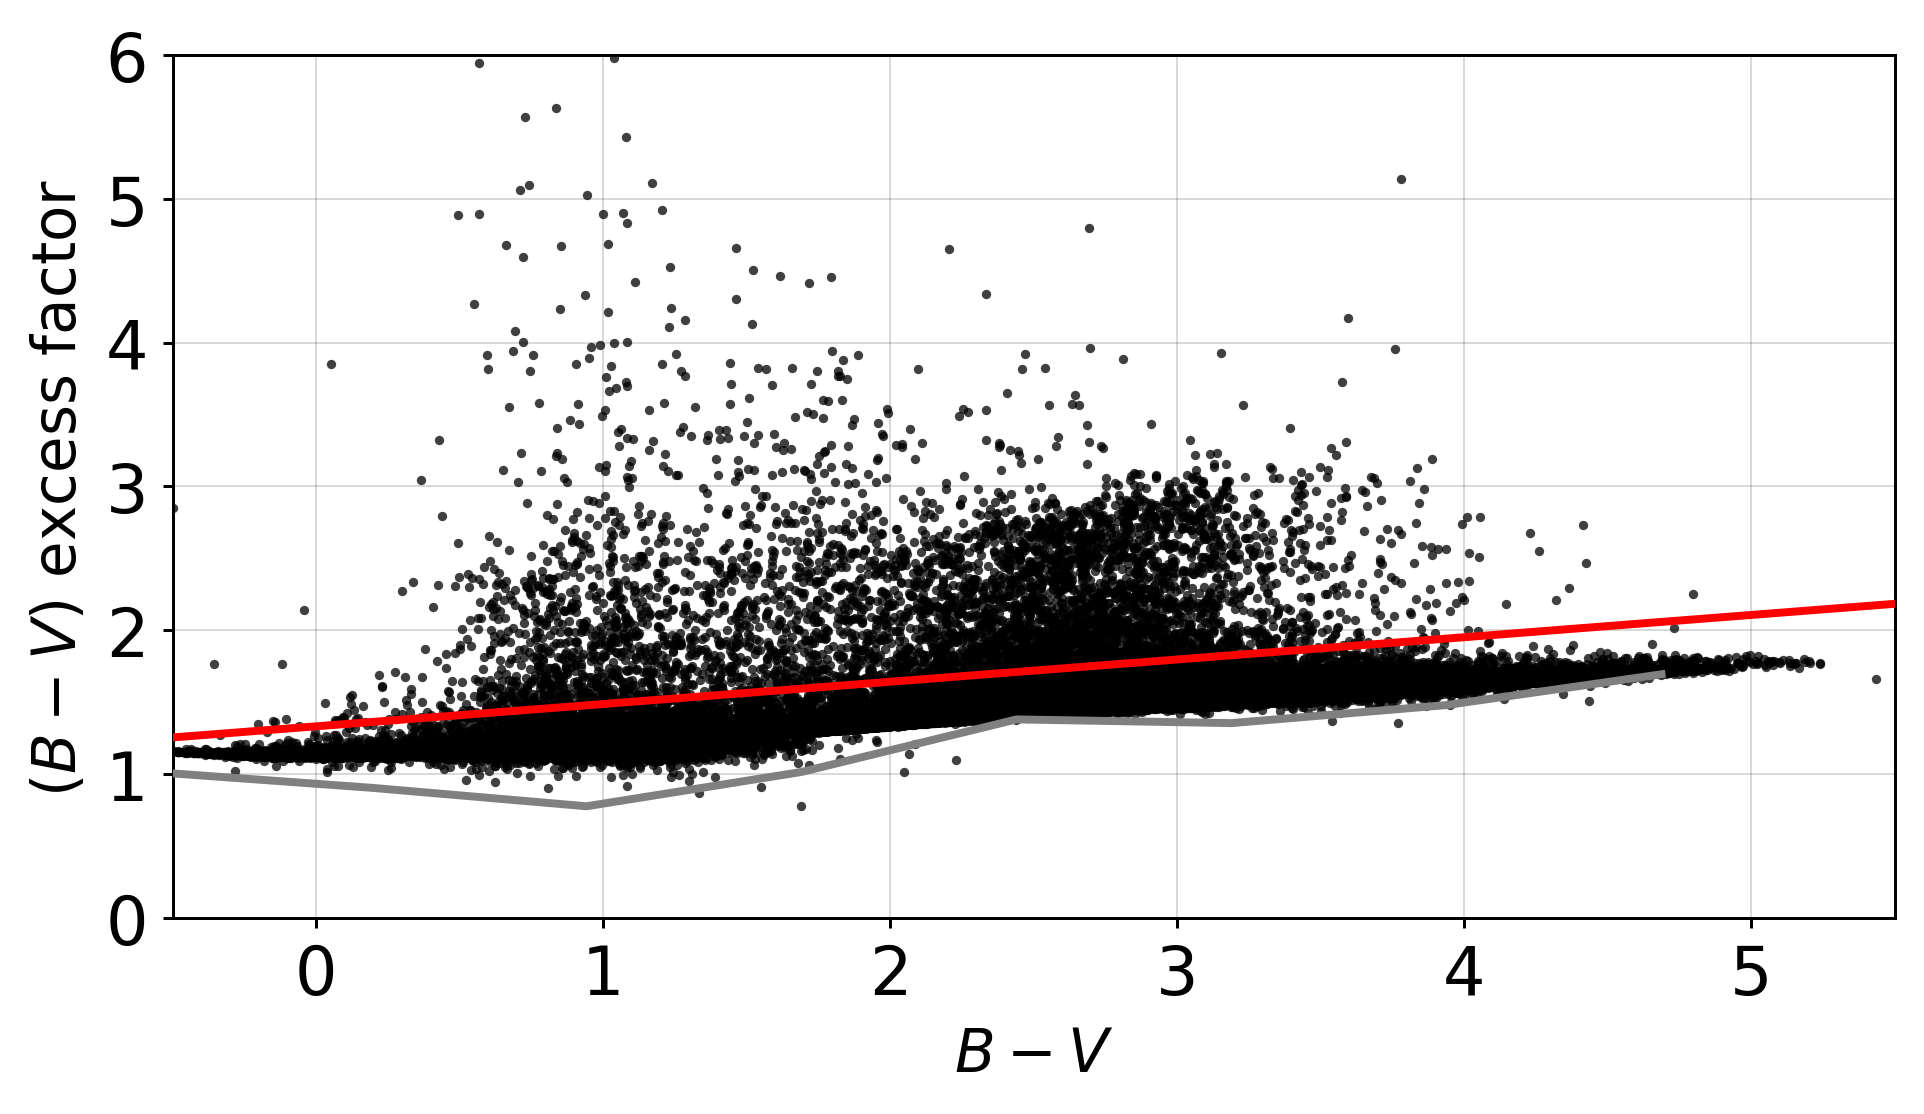

In [38]:
size, rat = 1080, 1.75
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=2.25, wspace=0.1)


slope_, intercept_ = 0.15488601077034136, 0.8818788505447561


min_lim = np.min(data_f2['bp_rp'])
#min_lim = 0.5
max_lim = np.max(data_f2['bp_rp'])
#max_lim = 3

# for each interval in bp_rp_arr, find tha min value of phot_bp_rp_excess_factor
bp_rp_arr = np.linspace(min_lim, max_lim, 10)
# Initialize an empty list to store the minimum values
min_values = []
for k in range(len(bp_rp_arr) - 1):
    lower_bound = bp_rp_arr[k]
    upper_bound = bp_rp_arr[k + 1]
        
    # Filter the data based on the current interval
    mask = (data_f2['bp_rp'] >= lower_bound) & (data_f2['bp_rp'] < upper_bound)
    filtered_data = data_f2['phot_bp_rp_excess_factor'][mask]
    
    # Find the minimum value in the filtered data
    if len(filtered_data) > 0:  # Check if there are any values in the current interval
        min_value = np.min(filtered_data)
        min_values.append(min_value)
    else:
        min_values.append(np.nan)  # Assign NaN if no values are found in the interval

min_values = np.array(min_values)

valid_mask = ~np.isnan(min_values)

# Filter out nan values
filtered_bp_rp = bp_rp_arr[:-1][valid_mask]
filtered_min_values = min_values[valid_mask]

# Perform the linear fit
#slope, intercept = np.polyfit(filtered_bp_rp[1:], filtered_min_values[1:], 1)

slope, intercept = slope_, intercept_

tol = 0.45

mask = data_f2['phot_bp_rp_excess_factor'] < slope * data_f2['bp_rp'] + intercept + tol
data_f3 = data_f2[mask]



axs[0][0].scatter(data_f2['bp_rp'], data_f2['phot_bp_rp_excess_factor'], 
            s=1*fs, c='k', alpha=0.75, zorder=3,
            linewidths=0.01*fs, edgecolor='k')

x1, x2 = -0.5, 6
p1, p2 = [x1, intercept + slope*x1 + tol], [x2,  intercept + slope*x2 + tol]
axs[0][0].plot([p1[0], p2[0]], [p1[1], p2[1]], color='r', linewidth=0.4*fs, label='Filter Threshold', zorder=3)
axs[0][0].plot(bp_rp_arr[:-1], min_values, color='grey', linewidth=0.4*fs, zorder=3)

# ax.set_xlim(-0.5,5)

axs[0][0].set_ylabel(r'$(B-V)$ excess factor', fontsize=3*fs)
axs[0][0].set_xlabel(r'$B-V$', fontsize=3*fs)

# # plot legend
# ax.legend(scatterpoints=1, frameon=True, 
#         labelspacing=0.1*fs, 
#         loc='upper left',
#         fontsize=2*fs)

axs[0][0].set_xlim(-0.5,5.5)
axs[0][0].set_ylim(0, 6)
# axs[0][1].set_ylim(1, 4)

# axs[0][1].yaxis.tick_right()
# axs[0][1].yaxis.set_label_position("right")

print(slope, intercept)


savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'excess_error_plot.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')



C:\Users\Pere\AppData\Local\Temp\ipykernel_27116\1511690342.py:17: RuntimeWarning: divide by zero encountered in log10
  colors = np.log10(ut.get_hist_scatter_colors(bp_rp_mag, g_abs,
C:\Users\Pere\AppData\Local\Temp\ipykernel_27116\1511690342.py:17: RuntimeWarning: divide by zero encountered in log10
  colors = np.log10(ut.get_hist_scatter_colors(bp_rp_mag, g_abs,


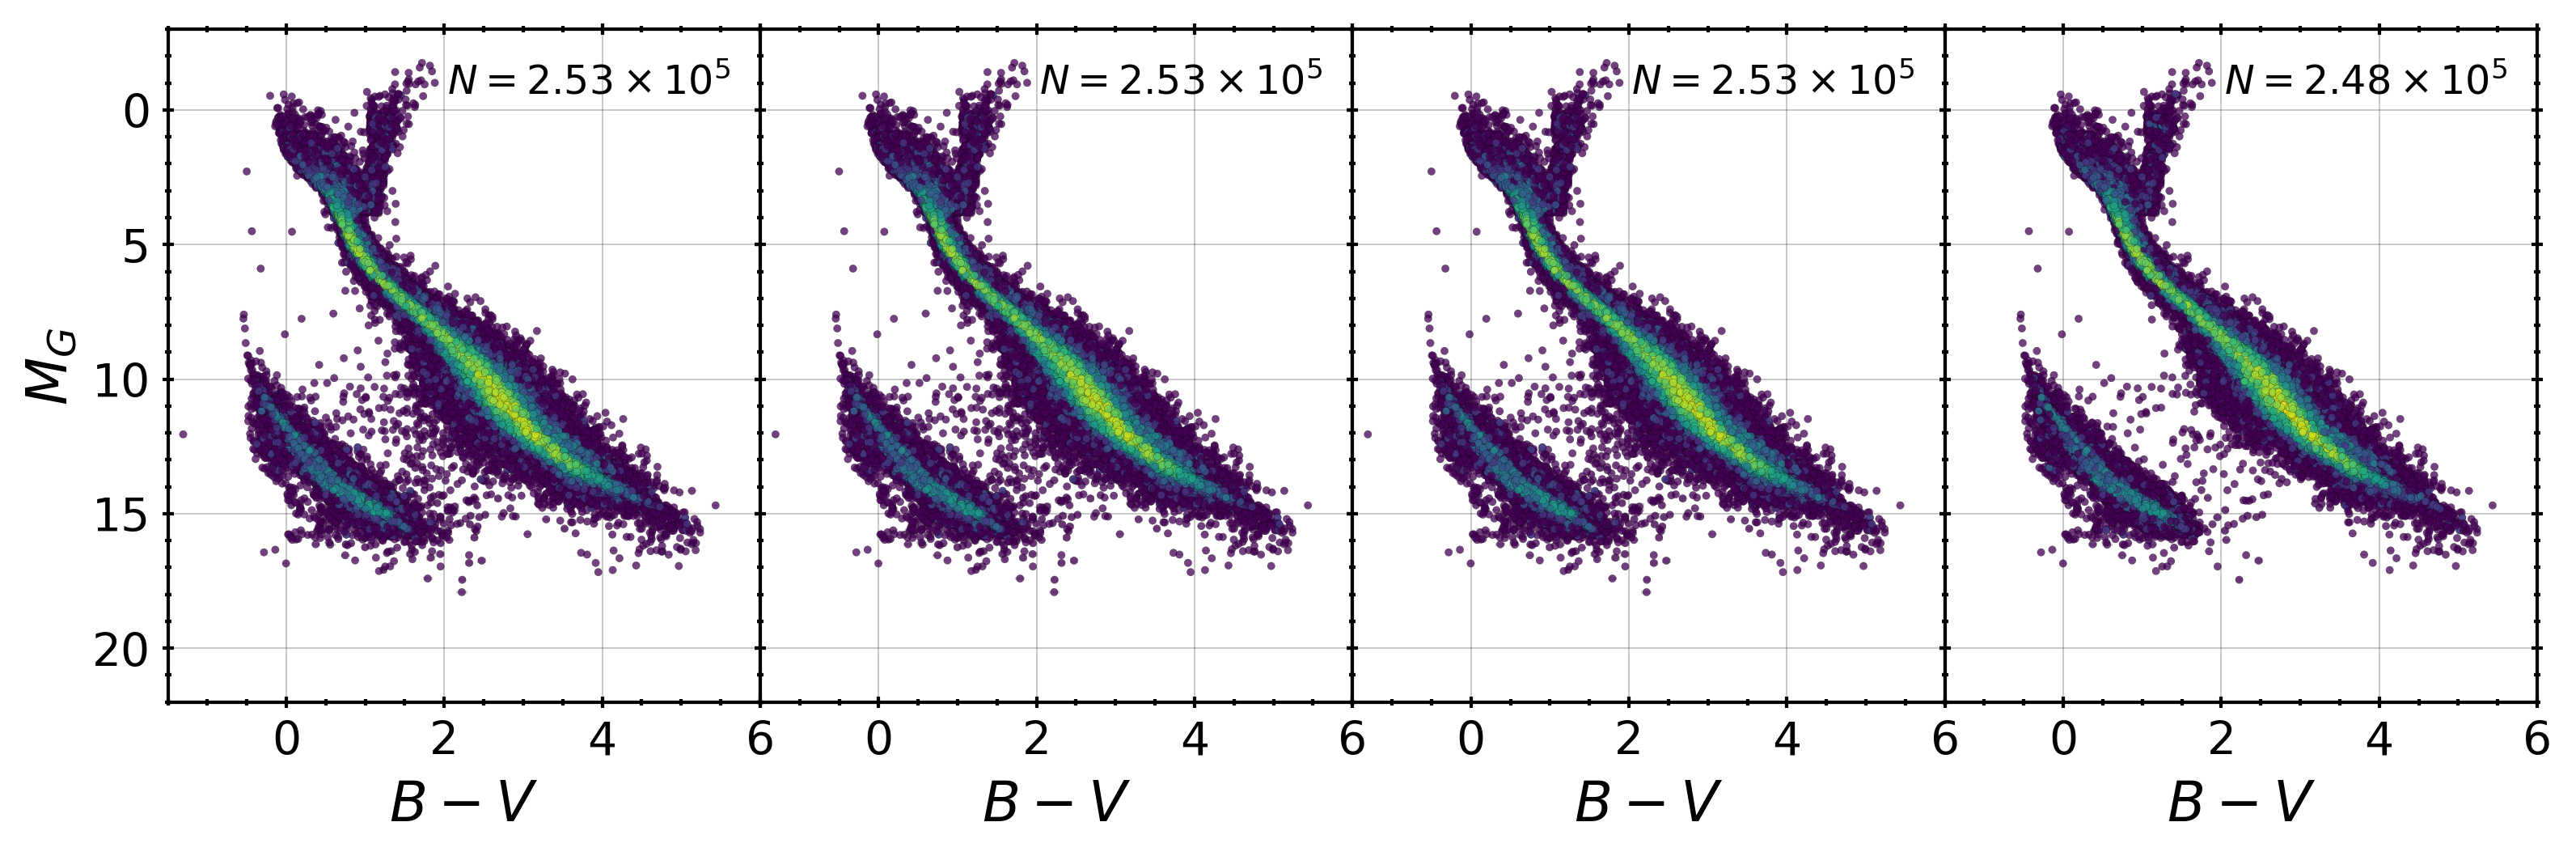

In [8]:
size, rat = 1080, 3.5
fig_w, fig_h = size*rat, size
subplots = (1, 4)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, 
                                   wspace=0, hspace=0, layout=None,
                                   top_bool=True, tick_direction='inout', minor=True)

cmap = mpl.colormaps['jet']

for i, data_ in enumerate([data, data_f1, data_f2, data_f3]):


    ax = axs[0][i]

    bp_rp_mag, g_abs = data_['bp_rp_mag'], data_['g_abs']
    colors = np.log10(ut.get_hist_scatter_colors(bp_rp_mag, g_abs,
                    x_lims=[np.min(bp_rp_mag), np.max(bp_rp_mag)],
                    y_lims=[np.min(g_abs), np.max(g_abs)],
                    bins=[200, 200]))

    ax.scatter(bp_rp_mag, g_abs, 
                s=0.75*fs, 
                c=colors, 
                alpha=0.75, zorder=2,
                linewidths=0.01*fs, edgecolor='k')

    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r'$M_G$', fontsize=2.45*fs)

    ax.set_xlim(-1.5,6)
    ax.set_ylim(-3, 22)
    ax.set_xlabel(r'$B-V$', fontsize=2.45*fs)

    ax.invert_yaxis()

    N = len(data_)
    N_sci = f'{(N):0.2e}'
    N_sci = N_sci.replace('e', ' \\times 10^{') + '}'
    if '+0' in N_sci:
        N_sci = N_sci.replace('+0', '')
    else:
        N_sci = N_sci.replace('+', '')
    ax.text(0.95, 0.95, r'$N = {}$'.format(N_sci), 
            transform=ax.transAxes, fontsize=1.75*fs, 
            verticalalignment='top', horizontalalignment='right')

    # if i==3:
        # Adding rectangles for each point to represent the errors
    color_max_err = np.percentile(np.array(data_['bp_rp_mag_error']),95)
    lum_max_err = np.percentile(np.array(data_['g_abs_error']),95)

    for xi, yi, x_err_i, y_err_i in zip(data_['bp_rp_mag'], data_['g_abs'], 
                                        data_['bp_rp_mag_error'], data_['g_abs_error']):
        
        if (x_err_i > color_max_err) or (y_err_i > lum_max_err):

            rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
            ax.add_patch(rect)

# savefold = '../figures/'
# if not os.path.exists(savefold):
#     # create the folder if it does not exist
#     os.makedirs(savefold)
# figname = f'filtering_plots.png'
# savepath = savefold + figname

# fig.savefig(savepath, dpi=300, bbox_inches='tight')

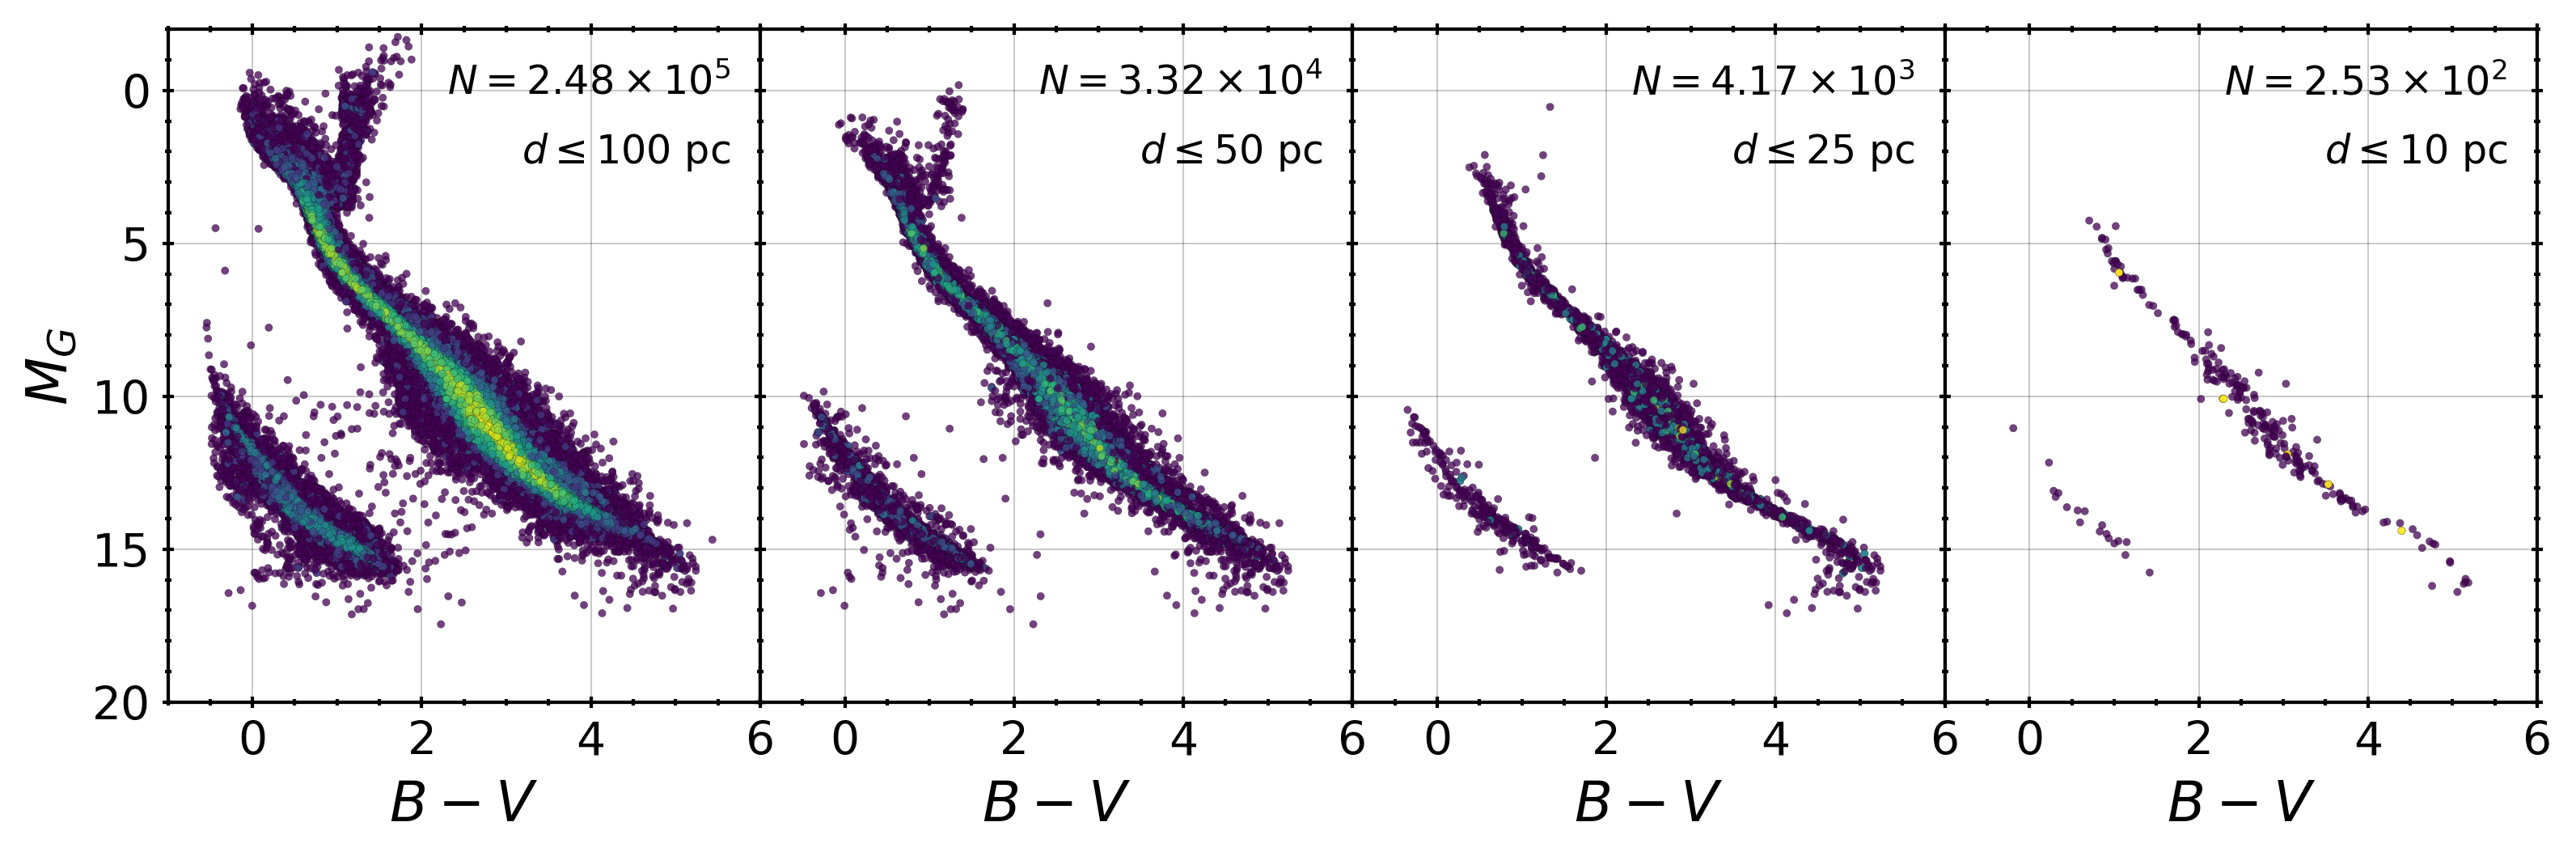

In [9]:
size, rat = 1080, 3.5
fig_w, fig_h = size*rat, size
subplots = (1, 4)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, 
                                   wspace=0, hspace=0, layout=None,
                                   top_bool=True, tick_direction='inout', minor=True)

cmap = mpl.colormaps['jet']

dists = [100, 50, 25, 10]

for i, dist in enumerate(dists):

    data_ = data_f3[data_f3['distance'] < dist]

    ax = axs[0][i]

    bp_rp_mag, g_abs = data_['bp_rp_mag'], data_['g_abs']
    colors = np.log10(ut.get_hist_scatter_colors(bp_rp_mag, g_abs,
                    x_lims=[np.min(bp_rp_mag), np.max(bp_rp_mag)],
                    y_lims=[np.min(g_abs), np.max(g_abs)],
                    bins=[200, 200]))

    ax.scatter(bp_rp_mag, g_abs, 
                s=0.75*fs, 
                c=colors, 
                alpha=0.75, zorder=2,
                linewidths=0.01*fs, edgecolor='k')

    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r'$M_G$', fontsize=2.45*fs)

    ax.set_xlim(-1,6)
    ax.set_ylim(-2, 20)
    ax.set_xlabel(r'$B-V$', fontsize=2.45*fs)

    ax.invert_yaxis()

    N = len(data_)
    N_sci = f'{(N):0.2e}'
    N_sci = N_sci.replace('e', ' \\times 10^{') + '}'
    if '+0' in N_sci:
        N_sci = N_sci.replace('+0', '')
    else:
        N_sci = N_sci.replace('+', '')
    ax.text(0.95, 0.95, r'$N = {}$'.format(N_sci), 
            transform=ax.transAxes, fontsize=1.75*fs, 
            verticalalignment='top', horizontalalignment='right')
    
    ax.text(0.95, 0.85, r'$d \leq {}$ pc'.format(dist), 
            transform=ax.transAxes, fontsize=1.75*fs, 
            verticalalignment='top', horizontalalignment='right')

    color_max_err = np.percentile(np.array(data_['bp_rp_mag_error']),95)
    lum_max_err = np.percentile(np.array(data_['g_abs_error']),95)

    # for xi, yi, x_err_i, y_err_i in zip(data_['bp_rp_mag'], data_['g_abs'], 
    #                                     data_['bp_rp_mag_error'], data_['g_abs_error']):
        
    #     if (x_err_i > color_max_err) or (y_err_i > lum_max_err):

    #         rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
    #         ax.add_patch(rect)


# savefold = '../figures/'
# if not os.path.exists(savefold):
#     # create the folder if it does not exist
#     os.makedirs(savefold)
# figname = f'HR_distance_plots.png'
# savepath = savefold + figname

# fig.savefig(savepath, dpi=300, bbox_inches='tight')


In [93]:
# import pandas as pd

# datasets = [data, data_f1, data_f2, data_f3, data_f4]

# # create a new empty pandas dataframe
# df = pd.DataFrame() 

# columns = [100, 50, 25, 10]
# rows = ['raw', 'f1', 'f2', 'f3', 'f4']

# dic = {}

# for dist in columns:
#     dic[dist] = []
#     for i, data_ in enumerate(datasets):
#         mask = data_['distance'] < dist
#         data__ = data_[mask]
#         dic[dist].append(len(data__))
# dic

{100: [47962, 34937, 33915, 33179, 248976],
 50: [47962, 34937, 33915, 33179, 33313],
 25: [5165, 4386, 4267, 4171, 4182],
 10: [311, 257, 255, 253, 254]}

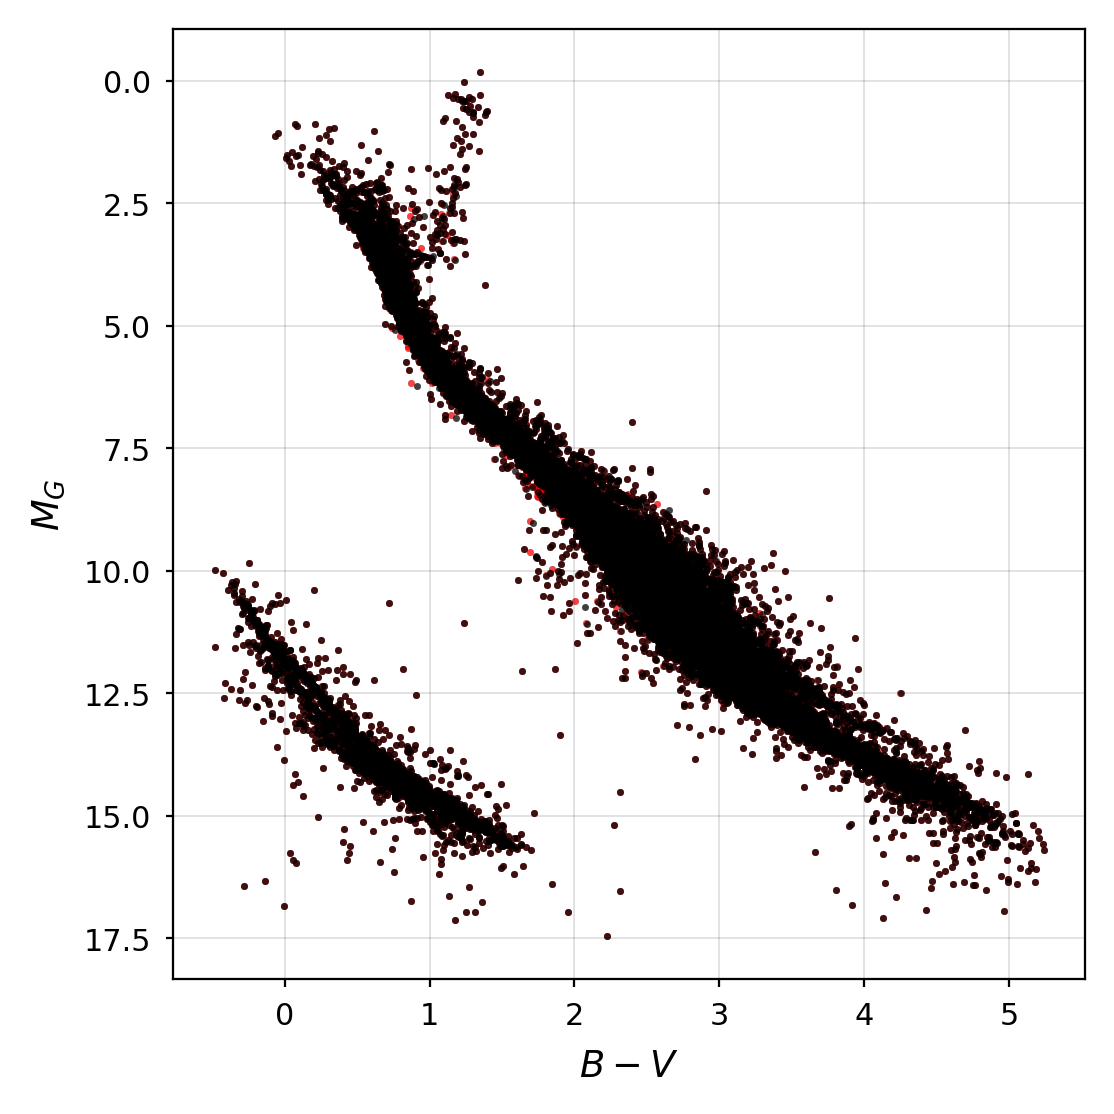

In [100]:
size, rat = 1080, 1
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

ax = axs[0][0]
cmap = mpl.colormaps['jet']

data_ = data_f3

bp_rp_mag, g_abs = data_['bp_rp_mag'], data_['g_abs']

bp_rp_mag_corr = bp_rp_mag  - data_['ebpminrp_gspphot'].filled(0)
g_abs_corr = g_abs - data_['ag_gspphot'].filled(0)

# colors = np.log10(ut.get_hist_scatter_colors(bp_rp_mag_corr, g_abs_corr,
#                   x_lims=[np.min(bp_rp_mag), np.max(bp_rp_mag)],
#                   y_lims=[np.min(g_abs), np.max(g_abs)],
#                   bins=[200, 200]))

ax.scatter(bp_rp_mag, g_abs, 
            s=0.75*fs, 
            #c=colors, 
            color='k',
            alpha=0.75, zorder=2,
            linewidths=0.01*fs, edgecolor='k')

ax.scatter(bp_rp_mag_corr, g_abs_corr, 
            s=0.75*fs, 
            #c=colors, 
            color='r',
            alpha=0.75, zorder=1,
            linewidths=0.01*fs, edgecolor='k')


# Adding rectangles for each point to represent the errors
# for xi, yi, x_err_i, y_err_i in zip(data['bp_rp_mag'], data['g_abs'], 
#                                     data['bp_rp_mag_error'], data['g_abs_error']):
#     rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
#     ax.add_patch(rect)

ax.set_xlabel(r'$B-V$', fontsize=2.45*fs)
ax.set_ylabel(r'$M_G$', fontsize=2.45*fs)

ax.invert_yaxis()

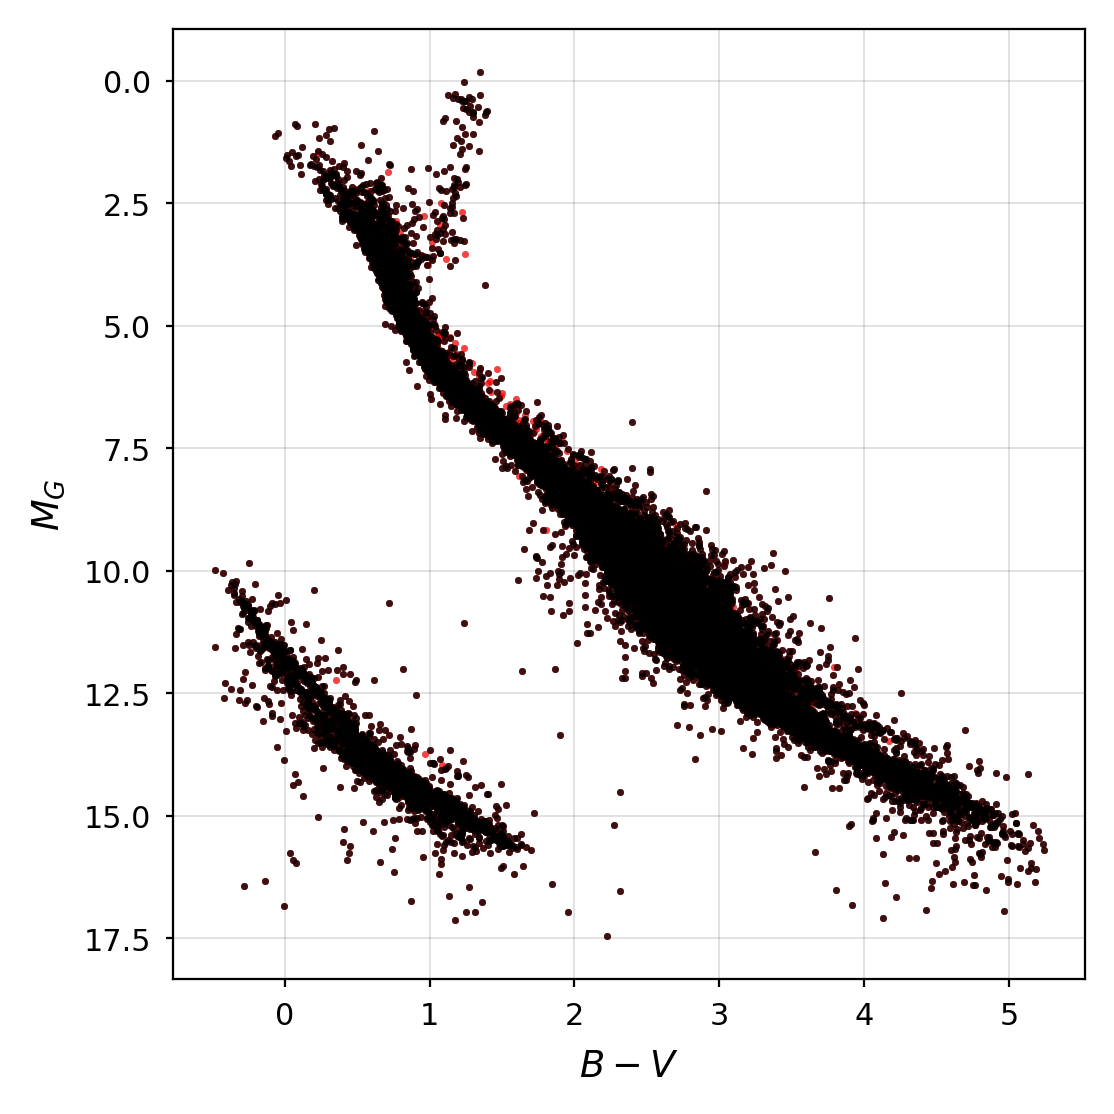

In [102]:
data_f4 = data_f3[data_f3['non_single_star'] == 0]

size, rat = 1080, 1
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

ax = axs[0][0]
cmap = mpl.colormaps['jet']

data_ = data_f4
data_2 = data_f3

bp_rp_mag, g_abs = data_['bp_rp_mag'], data_['g_abs']
bp_rp_mag_2, g_abs_2 = data_2['bp_rp_mag'], data_2['g_abs']

# colors = np.log10(ut.get_hist_scatter_colors(bp_rp_mag_corr, g_abs_corr,
#                   x_lims=[np.min(bp_rp_mag), np.max(bp_rp_mag)],
#                   y_lims=[np.min(g_abs), np.max(g_abs)],
#                   bins=[200, 200]))

ax.scatter(bp_rp_mag, g_abs, 
            s=0.75*fs, 
            #c=colors, 
            color='k',
            alpha=0.75, zorder=2,
            linewidths=0.01*fs, edgecolor='k')

ax.scatter(bp_rp_mag_2, g_abs_2, 
            s=0.75*fs, 
            #c=colors, 
            color='r',
            alpha=0.75, zorder=1,
            linewidths=0.01*fs, edgecolor='k')

# Adding rectangles for each point to represent the errors
# for xi, yi, x_err_i, y_err_i in zip(data['bp_rp_mag'], data['g_abs'], 
#                                     data['bp_rp_mag_error'], data['g_abs_error']):
#     rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
#     ax.add_patch(rect)

ax.set_xlabel(r'$B-V$', fontsize=2.45*fs)
ax.set_ylabel(r'$M_G$', fontsize=2.45*fs)

ax.invert_yaxis()

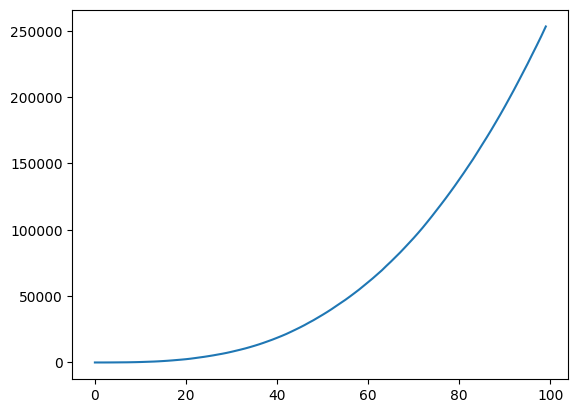

In [17]:
dists = np.linspace(1, 100, 100)
N_arr = np.zeros(len(dists))
for i, dist in enumerate(dists):
    data_ = data[data['distance'] < dist]
    N = len(data_)
    N_arr[i] = N

plt.plot(N_arr)

0.003802816380484728 0.0022485316446181967
0.43658536672592163 0.2769259512424469


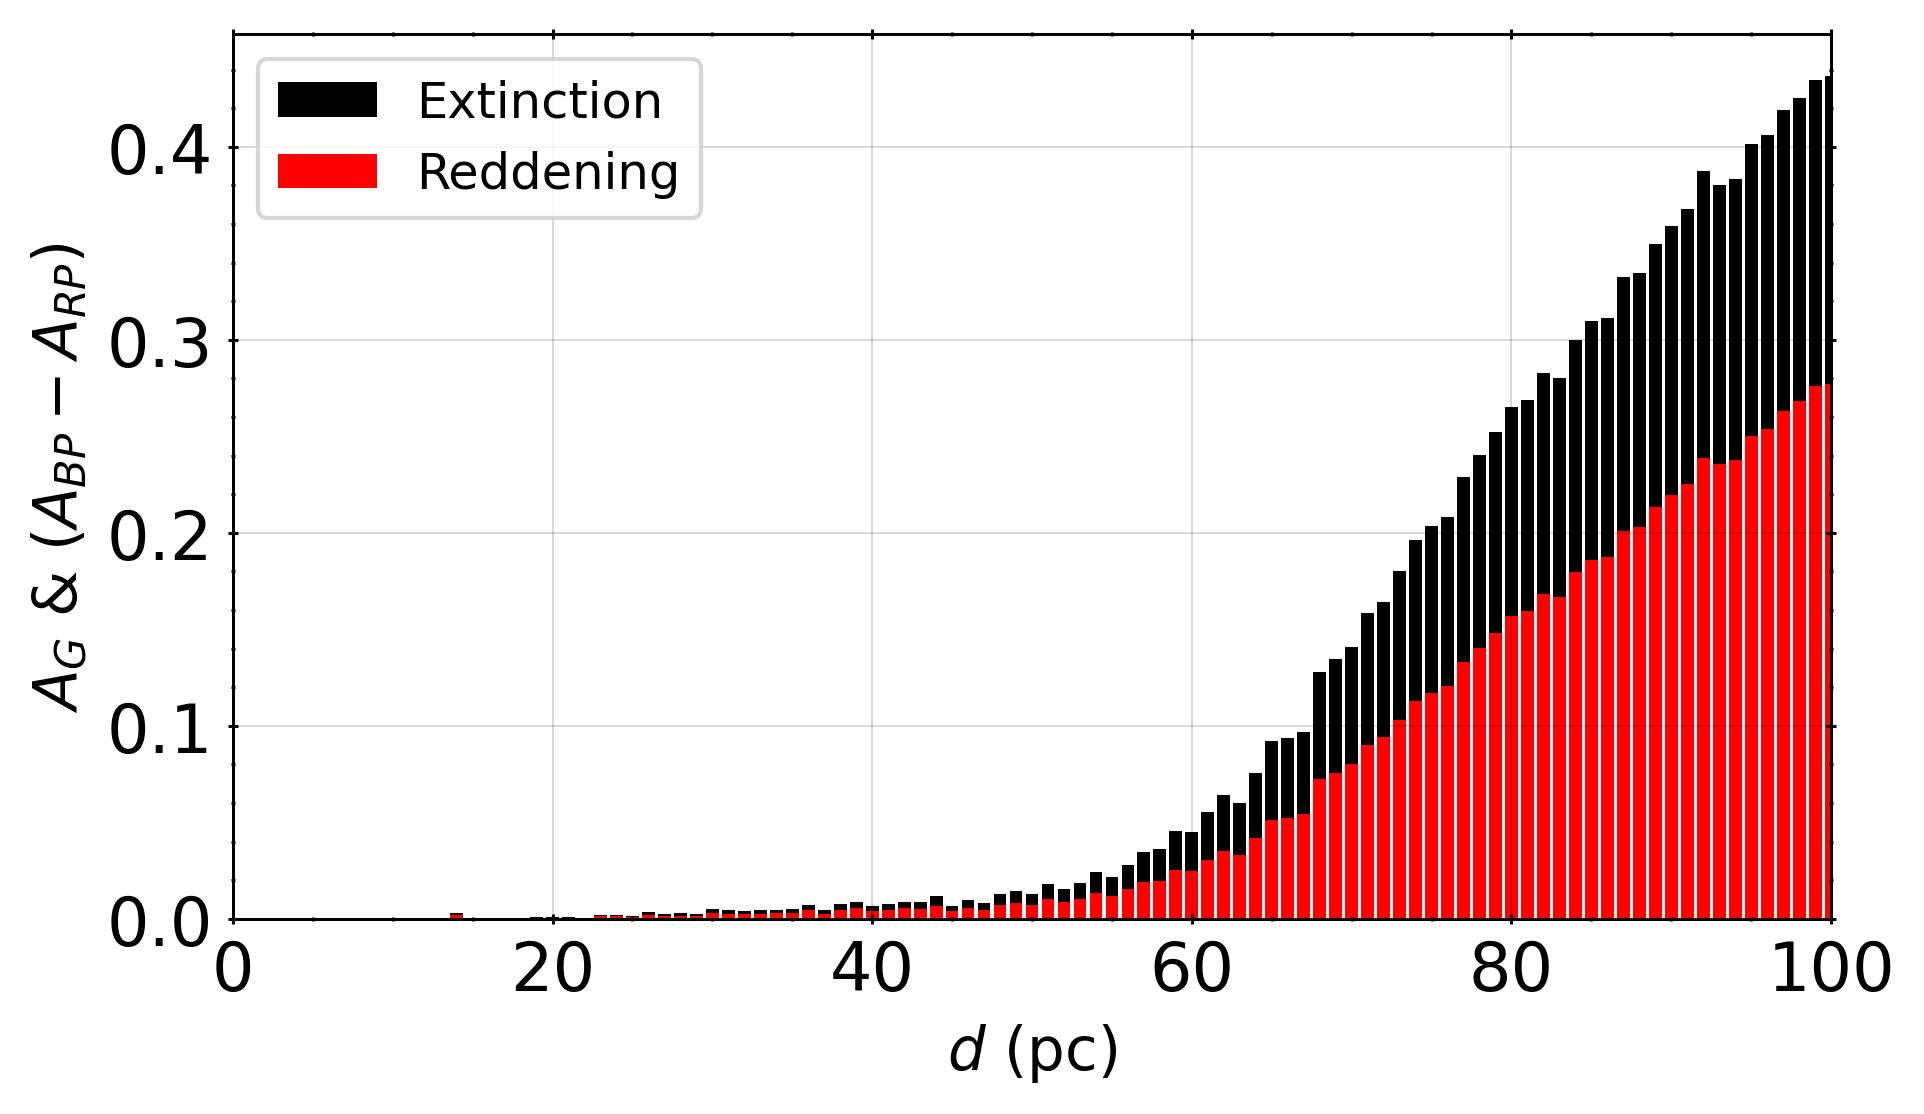

In [37]:
size, rat = 1080, 1.75
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=2.25, wspace=0.1,
                                   minor=True, top_bool=True, tick_direction='inout')
ax = axs[0][0]

dists = np.linspace(1, 100, 100)
ext_arr = np.zeros(len(dists))
ext_arr_min = np.zeros(len(dists))
ext_arr_max = np.zeros(len(dists))
red_arr = np.zeros(len(dists))
red_arr_min = np.zeros(len(dists))
red_arr_max = np.zeros(len(dists))
for i, dist in enumerate(dists[1:]):
    i+=1
    data_ = data[(data['distance'] < dist) & (data['distance'] > dists[i-1])]
    ext = np.nanmean(np.array(data_['ag_gspphot']))
    redd = np.nanmean(np.array(data_['ebpminrp_gspphot']))
    ext_min = np.nanmean(np.array(data_['ag_gspphot_lower']))
    ext_max = np.nanmean(np.array(data_['ag_gspphot_upper']))
    ext_arr[i] = ext
    ext_arr_min[i] = ext_min
    ext_arr_max[i] = ext_max

    red_min = np.nanmean(np.array(data_['ebpminrp_gspphot_lower']))
    red_max = np.nanmean(np.array(data_['ebpminrp_gspphot_upper']))

    red_arr[i] = redd
    red_arr_min[i] = red_min
    red_arr_max[i] = red_max

ax.bar(dists, ext_arr, color='k', label='Extinction')
ax.bar(dists, red_arr, color='r', label='Reddening')
# ax.fill_between(dists, ext_arr_min, ext_arr_max, alpha=0.5, color='k', label='Extinction conf. int.')
# ax.fill_between(dists, red_arr_min, red_arr_max, alpha=0.5, color='r', label='Reddening conf. int.')

ax.set_xlabel(r'$d$ (pc)', fontsize=3*fs)
ax.set_ylabel(r'$A_G$ & $(A_{BP} - A_{RP})$', fontsize=3*fs)

# legend
ax.legend(scatterpoints=1, frameon=True, 
        labelspacing=0.1*fs, 
        loc='upper left',
        fontsize=2.5*fs)

ax.set_xlim(0,100)

print(np.mean(ext_arr[:50]), np.mean(red_arr[:50]))
print(np.mean(ext_arr[99:]), np.mean(red_arr[99:]))

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'extintion.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')


0.39758604530467934 2.9024497270666436
b error: 0.0031069444449043134
c error: 0.0017499491310794659


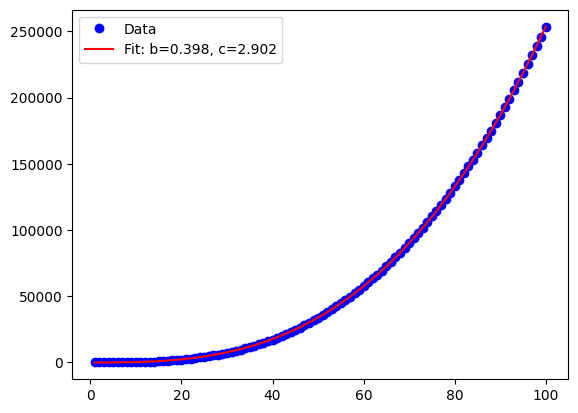

In [19]:

from scipy.optimize import curve_fit
def fit_function(x, b, c):
    return  b * x**c

initial_guess = [10, 3]

# Perform the curve fitting
popt, pcov = curve_fit(fit_function, dists, N_arr, p0=initial_guess)

# popt contains the best fit values for parameters a, b, and c
b_fit, c_fit = popt
print(b_fit, c_fit)

perr = np.sqrt(np.diag(pcov))
b_err, c_err = perr
print('b error:', b_err)
print('c error:', c_err)

# Plot the original data
plt.plot(dists, N_arr, 'bo', label='Data')

# Plot the fitted curve
plt.plot(dists, fit_function(dists, *popt), 'r-', label='Fit: b=%5.3f, c=%5.3f' % tuple(popt))

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [148]:
np.linspace(0,1100,10)

array([   0.        ,  122.22222222,  244.44444444,  366.66666667,
        488.88888889,  611.11111111,  733.33333333,  855.55555556,
        977.77777778, 1100.        ])